# Pyramid experiments

## 2D pyramid generation



In [179]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [233]:
class Pyramid3D:
    def __init__(self, height, base_size, levels, fov, skip=(0, 0)):
        self.height = height
        self.fov = fov
        self.base_size = base_size
        if isinstance(base_size, (int, float)):
            self.base_size = (base_size, base_size)
        self.L = levels
        self.skip = skip
        _, _, _ = self.find_step_sizes()
        self.apexes = self.generate_pyramid_apexes()

    def find_step_sizes(self, skip=(0, 0)):
        skip = self.skip if skip == (0, 0) else skip
        # base unit steps (no skip)
        self._base_step_x = self.base_size[0] / self.L
        self._base_step_y = self.base_size[1] / self.L
        self._stride_x = skip[0] + 1
        self._stride_y = skip[1] + 1
        self.dh = 2 * self.height / self.L
        self.dx = self._stride_x * self._base_step_x
        self.dy = self._stride_y * self._base_step_y
        return self.dh, self.dx, self.dy

    def height_levels(self, current_layer):
        return self.height * (self.L - current_layer + 1) / self.L

    def _start_offset(self, layer_k, axis=0):
        # Center remaining slack after applying stride r over m positions.
        r = self._stride_x if axis == 0 else self._stride_y
        m = layer_k
        n = math.ceil(m / r)
        slack = (m - 1) - r * (
            n - 1
        )  # number of base-steps not covered by selected indices
        return max(0, slack // 2)  # left/bottom slack

    def find_apex(self, current_layer, current_position):
        # current_position is 1..n_x and 1..n_y in the compact grid.
        # Map to original layer indices with stride and centered offset.
        # layer footprint anchors
        x0 = -self._base_step_x * (current_layer - 1) / 2
        y0 = -self._base_step_y * (current_layer - 1) / 2

        off_x = self._start_offset(current_layer, axis=0)
        off_y = self._start_offset(current_layer, axis=1)

        idx_x = off_x + (current_position[0] - 1) * self._stride_x
        idx_y = off_y + (current_position[1] - 1) * self._stride_y

        x = x0 + idx_x * self._base_step_x
        y = y0 + idx_y * self._base_step_y
        z = self.height_levels(current_layer)
        return (x, y, z)

    def count_positions_in_layer(self, layer_k, skip=(0, 0)):
        skip = self.skip if skip == (0, 0) else skip
        if layer_k % 2 == 0:
            return (0, 0)
        # Calculate number of positions in x and y directions for the given layer and skip

        n_x_k = math.ceil(layer_k / (skip[0] + 1))
        n_y_k = math.ceil(layer_k / (skip[1] + 1))
        return (n_x_k, n_y_k)

    def overlap_for_h(self, h=None, level=None, skip=(0, 0)):
        if skip != self.skip:
            dh, dx, dy = self.find_step_sizes(skip=skip)
        else:
            dh, dx, dy = self.dh, self.dx, self.dy

        if h is None and level is not None:
            h = self.height_levels(level)
        elif h is not None and level is None:
            w = 2 * h * math.tan(math.radians(self.fov / 2))
            return 1 - dx / w, 1 - dy / w
        elif h is None and level is None:
            os = {}
            for level in range(1, self.L + 1):
                h = self.height_levels(level)
                w = 2 * h * math.tan(math.radians(self.fov / 2))
                os[level] = (1 - dx / w, 1 - dy / w)
            return os
        else:
            raise ValueError("Either h or level must be provided, not both.")

    def generate_pyramid_apexes(self):
        apexes = []

        for layer in range(1, self.L + 1):
            if layer % 2 == 0:
                continue
            num_positions = self.count_positions_in_layer(layer)

            grid = (
                np.array(
                    np.meshgrid(
                        range(1, num_positions[0] + 1),
                        range(
                            1,
                            num_positions[1] + 1,
                        ),
                    )
                )
                .reshape(2, -1)
                .T
            )

            for position in grid:
                apex = self.find_apex(layer, position)
                apexes.append(apex)
        return apexes

    def plot_pyramid(self, side=False, level=None, overlap=None):
        x_coords, y_coords, z_coords = zip(*self.apexes)
        z_norm = (np.array(z_coords) - min(z_coords)) / (max(z_coords) - min(z_coords))
        colors = plt.cm.viridis(z_norm)
        if side:
            if level is not None:
                # Filter apexes for the specified level
                filtered_apexes = [
                    apex
                    for apex in self.apexes
                    if math.isclose(apex[2], self.height_levels(level), abs_tol=1e-2)
                ]
                if not filtered_apexes:
                    print(f"No apexes found for level {level}.")
                    return
                x_coords, y_coords, z_coords = zip(*filtered_apexes)
            plt.scatter(x_coords, y_coords)
            # Draw base rectangle
            base_x = [
                -self.base_size[0] / 2,
                self.base_size[0] / 2,
                self.base_size[0] / 2,
                -self.base_size[0] / 2,
                -self.base_size[0] / 2,
            ]
            base_y = [
                -self.base_size[1] / 2,
                -self.base_size[1] / 2,
                self.base_size[1] / 2,
                self.base_size[1] / 2,
                -self.base_size[1] / 2,
            ]
            plt.plot(base_x, base_y, "k--", linewidth=1)

            plt.xlim(-self.base_size[0] / 2 - 1, self.base_size[0] / 2 + 1)
            plt.ylim(-self.base_size[1] / 2 - 1, self.base_size[1] / 2 + 1)
            xn, yn = self.count_positions_in_layer(level)

            plt.title(f"Apexes at L={level} height= {z_coords[0]:.2f} (n={xn}x{yn})")
            plt.xlabel("X-axis")
            plt.ylabel("Y-axis")
            plt.grid()
            plt.gca().set_aspect("equal", adjustable="box")
            plt.show()
        else:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
            # Filter apexes based on overlap if overlap is specified
            if overlap is not None:
                filtered_apexes = []
                for apex, color in zip(self.apexes, colors):
                    # Calculate overlap for this apex's height (z)
                    h = apex[2]
                    ox, oy = self.overlap_for_h(h=h)
                    # Check if both overlaps are within the specified range
                    if (
                        overlap[0] <= ox <= overlap[1]
                        and overlap[0] <= oy <= overlap[1]
                    ):
                        filtered_apexes.append(apex)

                if filtered_apexes:
                    x_coords, y_coords, z_coords = zip(*filtered_apexes)
                    z_norm = (np.array(z_coords) - min(z_coords)) / (
                        max(z_coords) - min(z_coords)
                    )
                    colors = plt.cm.viridis(z_norm)

            ax.scatter(x_coords, y_coords, z_coords, c=colors, s=40)
            ax.set_title(f"3D Pyramid Apexes for overlap {overlap}")
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.set_zlabel("Z-axis")

            ax.set_zlim(0, self.height + 1)
            ax.set_xlim(-self.base_size[0] / 2 - 1, self.base_size[0] / 2 + 1)
            ax.set_ylim(-self.base_size[1] / 2 - 1, self.base_size[1] / 2 + 1)
            ax.set_box_aspect([self.base_size[0], self.base_size[1], self.height])

            plt.show()

    def get_confuguration_space(self, overlap=None):
        print(f"Step sizes (dh, dx, dy): {self.dh}, {self.dx}, {self.dy}")
        for level in range(1, self.L + 1):
            if level % 2 == 0:
                continue
            h = self.height_levels(level)
            xn, yn = self.count_positions_in_layer(level)
            ox, oy = pyramid.overlap_for_h(h=h)
            if overlap[0] <= ox <= overlap[1] and overlap[0] <= oy <= overlap[1]:

                print(
                    f"L={level}, height={h:.2f}, n_steps=({xn:.2f}, {yn:.2f}), o=({ox:.2f}, {oy:.2f})"
                )

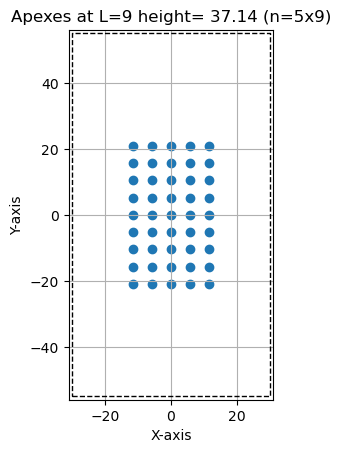

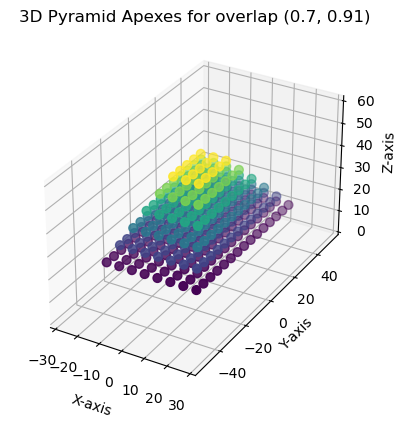

Step sizes (dh, dx, dy): 5.714285714285714, 5.714285714285714, 5.238095238095238
L=5, height=48.57, n_steps=(3.00, 5.00), o=(0.90, 0.91)
L=7, height=42.86, n_steps=(4.00, 7.00), o=(0.88, 0.89)
L=9, height=37.14, n_steps=(5.00, 9.00), o=(0.87, 0.88)
L=11, height=31.43, n_steps=(6.00, 11.00), o=(0.84, 0.86)
L=13, height=25.71, n_steps=(7.00, 13.00), o=(0.81, 0.82)
L=15, height=20.00, n_steps=(8.00, 15.00), o=(0.75, 0.77)
None


In [234]:
field = (60, 110)
fov = 60
pyramid = Pyramid3D(height=60, base_size=field, levels=21, fov=fov, skip=(1, 0))
pyramid.plot_pyramid(side=True, level=9)
pyramid.plot_pyramid(side=False, overlap=(0.7, 0.91))
print(pyramid.get_confuguration_space(overlap=(0.7, 0.91)))